<a href="https://colab.research.google.com/github/terkoizmy/Population/blob/main/Population.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forcasting with SARIMA and assumtion test

## install and import library

In [1]:
!pip install pmdarima

In [2]:
!pip install pandas==0.23.4

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Prepare dataset

In [4]:
series = pd.read_csv('POP.csv',
                       index_col ='date',
                       parse_dates = True)

In [5]:
series.head()

,realtime_start,value,realtime_end
date,,,
1952-01-01,2019-12-06,156309.0,2019-12-06
1952-02-01,2019-12-06,156527.0,2019-12-06
1952-03-01,2019-12-06,156731.0,2019-12-06
1952-04-01,2019-12-06,156943.0,2019-12-06
1952-05-01,2019-12-06,157140.0,2019-12-06


In [6]:
print(series.index.min(), "start")
print(series.index.max(), "end")

1952-01-01 00:00:00 start
2019-12-01 00:00:00 end


In [7]:
pd.date_range(start = '1952-01-01', end = '2019-12-01').difference(series.index)

DatetimeIndex(['1952-01-02', '1952-01-03', '1952-01-04', '1952-01-05',
               '1952-01-06', '1952-01-07', '1952-01-08', '1952-01-09',
               '1952-01-10', '1952-01-11',
               ...
               '2019-11-21', '2019-11-22', '2019-11-23', '2019-11-24',
               '2019-11-25', '2019-11-26', '2019-11-27', '2019-11-28',
               '2019-11-29', '2019-11-30'],
              dtype='datetime64[ns]', length=23991, freq=None)

In [8]:
series.isna().sum()

realtime_start    0
value             0
realtime_end      0
dtype: int64

In [9]:
series = series.drop(["realtime_start", "realtime_end"], axis=1)
series.head()

,value
date,
1952-01-01,156309.0
1952-02-01,156527.0
1952-03-01,156731.0
1952-04-01,156943.0
1952-05-01,157140.0


## Split data

In [10]:
train_series = series.head(60 * 12)
test_series = series.tail(7 * 12)

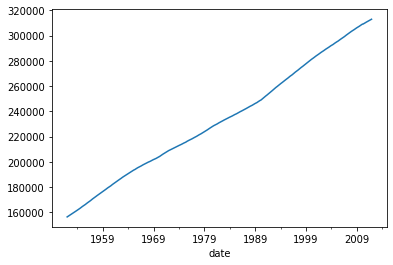

In [11]:
train_series['value'].plot()
plt.show()

In [12]:
series.head()

,value
date,
1952-01-01,156309.0
1952-02-01,156527.0
1952-03-01,156731.0
1952-04-01,156943.0
1952-05-01,157140.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  after removing the cwd from sys.path.


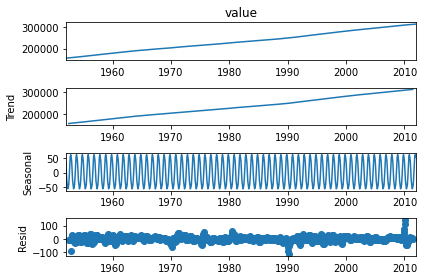

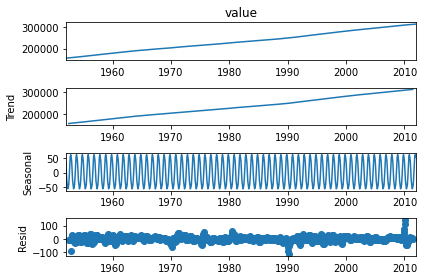

In [13]:
# ETS Decomposition
result = seasonal_decompose(train_series['value'], 
                            model ='additive',
                            freq = 12)
  
# ETS plot 
result.plot()

# ADF test
with adf test we can checking the data is stasioner or not.
and if the p-value is upper than 0.05, the data not stasioner. coz that we need do a differencing the trend and seasonal data

In [14]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

print(adf_test(train_series['value']))

Results of Dickey-Fuller Test:
Test Statistic                  -0.041374
p-value                          0.954974
#Lags Used                      17.000000
Number of Observations Used    702.000000
Critical Value (1%)             -3.439700
Critical Value (5%)             -2.865666
Critical Value (10%)            -2.568967
dtype: float64
None


with adf test we now the data not stasioner bcz the p-value is upper then 0.05, we need do a differencing with the trend and seasonal

## differencing the trend

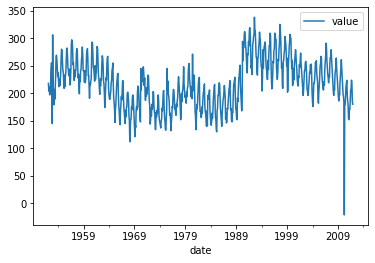

In [15]:
ts_diff_trend = train_series - train_series.shift(1)
ts_diff_trend = ts_diff_trend.dropna()
ts_diff_trend.plot()

In [16]:
print(adf_test(ts_diff_trend['value']))

Results of Dickey-Fuller Test:
Test Statistic                  -2.368568
p-value                          0.150805
#Lags Used                      16.000000
Number of Observations Used    702.000000
Critical Value (1%)             -3.439700
Critical Value (5%)             -2.865666
Critical Value (10%)            -2.568967
dtype: float64
None


after differencing with the trend the p-value still upper then 0.05, we need differencing the seasonal

## differencing the seasonal

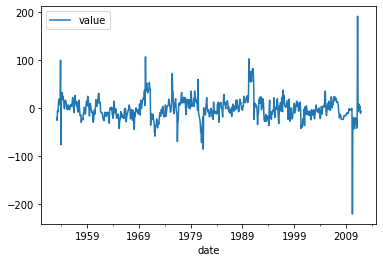

In [17]:
ts_seasonal = ts_diff_trend - ts_diff_trend.shift(12)
ts_seasonal = ts_seasonal.dropna()
ts_seasonal.plot()

In [18]:
print(adf_test(ts_seasonal['value']))

Results of Dickey-Fuller Test:
Test Statistic                  -4.978216
p-value                          0.000025
#Lags Used                      14.000000
Number of Observations Used    692.000000
Critical Value (1%)             -3.439835
Critical Value (5%)             -2.865726
Critical Value (10%)            -2.568999
dtype: float64
None


and now the p-value < 0.05 and we can doing to the next step

In [19]:
import warnings
warnings.filterwarnings('ignore')
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [20]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_series,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:19843.12019725069
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:19020.894083756284
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:13154.487298150445
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:12869.03196206643
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:11018.418044565227
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:10936.564933460057
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:9273.930256880918
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:9267.684814689539
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:19286.634225037684
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:18836.999288926272
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:12761.160108007847
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:13216.032897233948
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:18837.264791517515
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:19874.304691204947
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:12355.306768489365
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:8424.10989935821
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:9799.963210408501
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:8770.730130426668


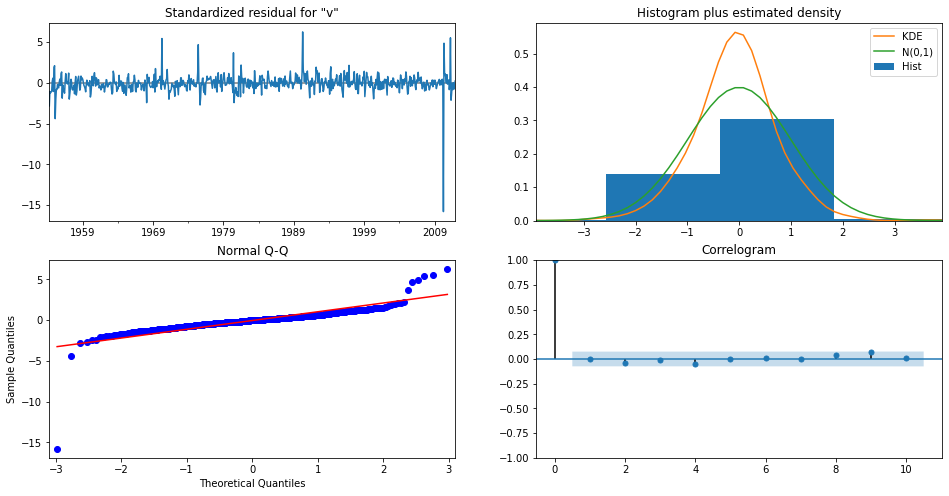

In [21]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [22]:
mod1 = sm.tsa.statespace.SARIMAX(train_series,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results1 = mod1.fit()
print(results1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9491      0.016     58.631      0.000       0.917       0.981
ma.L1         -0.5725      0.026    -22.118      0.000      -0.623      -0.522
ar.S.L12      -0.5397      0.011    -47.790      0.000      -0.562      -0.518
sigma2       260.6408      2.865     90.988      0.000     255.026     266.255


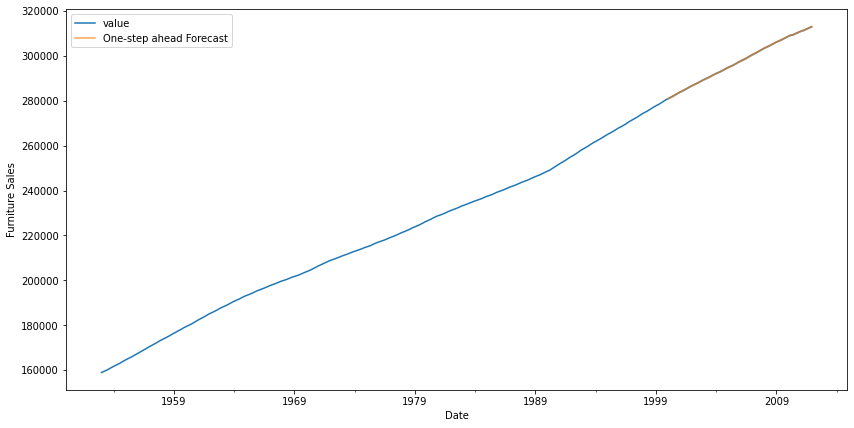

In [23]:
pred = results1.get_prediction(start=pd.to_datetime('2000-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = train_series['1953':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

## cek score with MAE and MAPE

In [24]:
y_forecasted = pred.predicted_mean
y_truth = train_series.value['2000-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 542.44


In [25]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 23.29


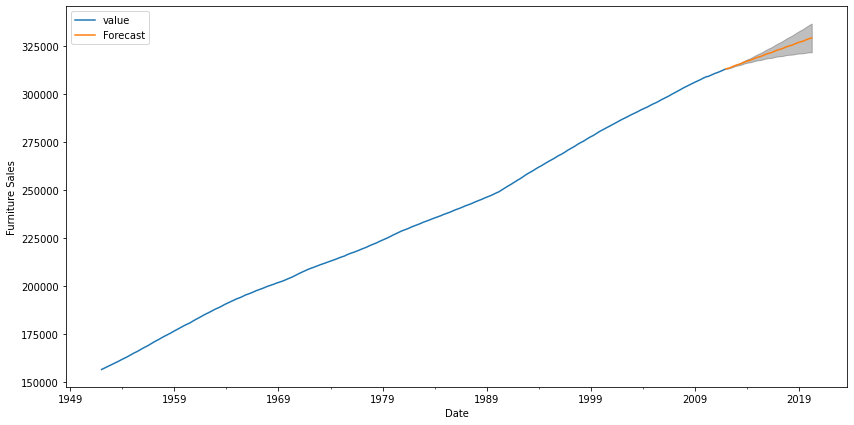

In [26]:
pred_uc = results1.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = train_series.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

## Assumption with Ljung box
H0: The residuals are independently distributed

HA: The residuals are not independently distributed; they exhibit serial correlation.

In [32]:
sm.stats.acorr_ljungbox(results1.resid, lags=[12], return_df=True)

,lb_stat,lb_pvalue
12,179.126487,6.446104e-32


The test statistic of the test is 179.126487 and the p-value of the test is 6.446104e-32, which is much less than 0.05. Thus, we reject the null hypothesis of the test and conclude that the residuals are not independent.